In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xlrd

### Read in data

We want to read in the spreadsheet and then validate that the data seems to have read in corectly.  I'll then get rid of some columns that don't have any value.

In [70]:
df = pd.read_excel('TestData.xlsx', skiprows=2, engine='openpyxl')
df.head(2)

,ACTIVITYID,PGID,OID,RPID,PATID,USERID,SESSIONID,WEBSERVERIP,REMOTEIP,PAGENAME,CREATEDON
0,1875082,40081,100,0,0,USER40081,pgdwm055edgvwqf5kb2rzg55,XXX.XX.XXX.110,172.130.400.165,Login - 172.130.400.165,2019-03-24 18:04:29.030
1,1875083,40081,100,0,0,USER40081,pgdwm055edgvwqf5kb2rzg55,XXX.XX.XXX.110,172.130.400.165,SearchPatients,2019-03-24 18:04:29.077


In [71]:
df.tail(2)

,ACTIVITYID,PGID,OID,RPID,PATID,USERID,SESSIONID,WEBSERVERIP,REMOTEIP,PAGENAME,CREATEDON
19055,2074073,40081,100,155,163,USER_N,mrcjgjm2kvrakv45mcxelgbk,XXX.XX.XXX.107,172.130.400.165,PatientView,2021-10-28 09:51:19.993
19056,2074074,40081,100,155,163,USER_N,mrcjgjm2kvrakv45mcxelgbk,XXX.XX.XXX.107,172.130.400.165,NewReports,2021-10-28 09:51:24.870


It looks like the headers read in correctly and that there are 19,057 records.  Let's check the distribution on some of these values.

In [72]:
# get number of rows
len(df)

19057

In [73]:
df.PGID.value_counts()

40081    19057
Name: PGID, dtype: int64

PGID is the same for all rows so it does not contains any useful information.

In [74]:
df.OID.value_counts()

100    18400
101      640
102       17
Name: OID, dtype: int64

There are different values for OID but since I don't know what it is there is no reason to keep it.

In [75]:
df.RPID.value_counts()[:10]

110    4645
130    3028
122    2280
131    1355
155     923
128     903
158     627
135     590
123     482
145     478
Name: RPID, dtype: int64

In [76]:
df.USERID.value_counts()

USER_N        16601
USER40081      1245
EN-USER         685
BPKUSER         265
USERVBS         133
USER_PRO         88
TESTRAHUL4       20
USER_1           11
USER_2            9
Name: USERID, dtype: int64

In [77]:
len(df.SESSIONID.unique())

1239

In [78]:
df.WEBSERVERIP.value_counts()[:10]

XXX.XX.XXX.101    1310
XXX.XX.XXX.114    1185
XXX.XX.XXX.109    1107
XXX.XX.XXX.110    1084
XXX.XX.XXX.105    1057
XXX.XX.XXX.112    1018
XXX.XX.XXX.116     962
XXX.XX.XXX.120     959
XXX.XX.XXX.115     954
XXX.XX.XXX.104     901
Name: WEBSERVERIP, dtype: int64

In [79]:
df.REMOTEIP.value_counts()[:10]

172.130.400.165    12731
12.139.39.74        3033
47.33.77.56          465
XXX.XX.XXX.252       442
XXX.XX.XXX.251       276
47.148.80.223        140
123.253.65.215       122
104.42.177.137       114
12.147.0.60          100
115.127.66.180        95
Name: REMOTEIP, dtype: int64

**Finding**
We see that nine different users show up in the data but almost all (87%) the use is by one user (USER_N).  One concern here is that while multiple people could be using the same login, there are many logins that are barely using the software.  The concern here is that maybe 4 people are using the same login but the customer is licensed for at least nine user so it would be hard to show a violation of the license.

**Question**
There seems to be a significant number of IP addresses using the software.  I'll need to lookup the region for these and see if they all map to reasonable locations.  Note two of the IP's seem to map to addresses in the format of the webserver ip and I assume those are from the vendor's customer support users, not end-user use.  We should validate that assumption at some point.

I'm going to assume that the SERVERIP column contains no useful information from the perspective of processing customer transactions since the customer does not select which server is used.


### Data Cleanup

Next we'll do a bit of cleanup such as remove the PGID column.  I'll also convert the timestamp into a datetime data time so we can do computations on it.

In [80]:
df['timestamp'] = pd.to_datetime(df.CREATEDON)
del(df['PGID'])
del(df['OID'])
del(df['CREATEDON'])
df.head(2)

,ACTIVITYID,RPID,PATID,USERID,SESSIONID,WEBSERVERIP,REMOTEIP,PAGENAME,timestamp
0,1875082,0,0,USER40081,pgdwm055edgvwqf5kb2rzg55,XXX.XX.XXX.110,172.130.400.165,Login - 172.130.400.165,2019-03-24 18:04:29.030
1,1875083,0,0,USER40081,pgdwm055edgvwqf5kb2rzg55,XXX.XX.XXX.110,172.130.400.165,SearchPatients,2019-03-24 18:04:29.077


### Sessions

Let's look at sessions some.  The first thing I'm curious about is how many pages are there in a typical session and does that vary by user.  This shows us the sessions for each user and the number of pages in each session.  This is just a subset of the whole data.

In [47]:
df.groupby(['USERID', 'SESSIONID']).PAGENAME.count()

USERID    SESSIONID               
BPKUSER   1r5q0zzejbumgb55p3ulw155     2
          44hdb355tbxsfyekdnf04d45    42
          4enur1je4o4al0z3xrqa0b45    25
          4tgb3b45urm3py45nwynkxa1    79
          azk0vhelh5geow45kwsv1yvd    23
                                      ..
USER_PRO  2lqt5mqehdnknp55p1hrah55    38
          ctgigrrw0lvmulnt3svw3u45    29
          s224nz2twufzp555w4j1ld45     7
          vhxrfznwwzaxb355gxmmr555     2
          yw5u4ia5sk1plcfrwpqe1yih     5
Name: PAGENAME, Length: 1258, dtype: int64

This looks pretty reasonable at this point as there is a good distribution of session sizes which I would expect.  This also seems to be true for all the users shown.  This makes me wonder what the duration of each session is.  I would expect the duration to be somewhat related to the number of commands (assuming the session is automatically terminated after some period of inactivity).

In [83]:
for k, gbdf in df.groupby(['USERID', 'SESSIONID']):
    user, session = k
    number_of_pages = gbdf.PAGENAME.count()
    duration = max(gbdf.timestamp) - min(gbdf.timestamp)
    print(f"{user:10s}, {session}, {number_of_pages:3d} pages - {duration}")

BPKUSER   , 1r5q0zzejbumgb55p3ulw155,   2 pages - 0 days 00:00:08.537000
BPKUSER   , 44hdb355tbxsfyekdnf04d45,  42 pages - 40 days 02:54:21.880000
BPKUSER   , 4enur1je4o4al0z3xrqa0b45,  25 pages - 8 days 15:43:28.413000
BPKUSER   , 4tgb3b45urm3py45nwynkxa1,  79 pages - 26 days 01:41:00.843000
BPKUSER   , azk0vhelh5geow45kwsv1yvd,  23 pages - 1 days 08:49:47.370000
BPKUSER   , c00tquezxplqlryrydlbes3p,  14 pages - 13 days 09:16:26.766000
BPKUSER   , fjvnrmvf1n4tr5fjfgqlup55,   6 pages - 0 days 22:53:10.394000
BPKUSER   , gmyshsmxjnyb5ziljx0mu4zc,   4 pages - 0 days 04:08:00.870000
BPKUSER   , j1rkro450w3wnwrv1naej5b3,   7 pages - 0 days 00:12:02.720000
BPKUSER   , kgmh0znei3fokp455lbqpkye,   2 pages - 0 days 00:00:18.577000
BPKUSER   , ky5xyj554bgkcl45kngcab55,   6 pages - 6 days 23:55:20.666000
BPKUSER   , naahh5u5rbxgrm553wj2f155,   5 pages - 0 days 00:02:36.400000
BPKUSER   , nna3zq553urqeu45gbjmsu45,   1 pages - 0 days 00:00:00
BPKUSER   , nuhz3qfqdpqviv2ukbigiyzj,   2 pages - 0 day

USER_N    , 52lpfq45w4bdr4455z3gos55,  15 pages - 0 days 01:12:45.370000
USER_N    , 53izlxyq3fttco55usaygirn,   3 pages - 0 days 00:00:11.347000
USER_N    , 541jxm552gh13t55nqmvzd55,   6 pages - 0 days 00:10:38.960000
USER_N    , 5b0kfv45lj4bjv55jhbxtu55,   2 pages - 0 days 00:00:27.110000
USER_N    , 5biwk445roaenwjnpurrwvn5,   5 pages - 0 days 00:00:17.780000
USER_N    , 5ca4xm55tukxgiqk4mslbe45,   4 pages - 0 days 00:03:29.837000
USER_N    , 5ckymw55hovsfn55bgtahz55,   5 pages - 0 days 00:00:18.030000
USER_N    , 5dnqf2zkkwlmzzvokytb1qef,  27 pages - 0 days 00:27:57.773000
USER_N    , 5g0a5z45ckilrv45rsyv4gno,   1 pages - 0 days 00:00:00
USER_N    , 5gk4dke2bnpjid45evpftw45,  47 pages - 0 days 13:17:53.940000
USER_N    , 5gzaxa55ffvrdvmyveupq545,  25 pages - 0 days 00:14:44.403000
USER_N    , 5hf0cf55ybnvmh55idc2a0ih,   5 pages - 0 days 00:00:36.873000
USER_N    , 5htqe355uho3gfuuv0bhsa45,   2 pages - 0 days 00:00:10.834000
USER_N    , 5ivfkkipzsauzwb54t5kqb45,   3 pages - 0 days 0

USER_N    , iv4eyt553qb4ounbvjkxgz45,   2 pages - 0 days 00:00:00.030000
USER_N    , ix22v0qxh1ftoh45oazafh55,   2 pages - 0 days 00:00:03.844000
USER_N    , ixah0g455c0mfanvo4eakgud, 207 pages - 1 days 02:00:40.473000
USER_N    , ixm1ygiiuswybm5552x2iaet,   2 pages - 0 days 00:48:09.403000
USER_N    , j0lk5i55naripu55klwo2245,   8 pages - 0 days 06:00:55.266000
USER_N    , j0nh2qyprk52av45jit1ju55,   3 pages - 0 days 00:00:11.994000
USER_N    , j1fjq2bydunhan55ecqorifd,   2 pages - 0 days 00:00:03.503000
USER_N    , j1hhgdycvldrq34542mih355,  16 pages - 0 days 00:16:51.997000
USER_N    , j2tot2y15vx5wz55lkeang55,  23 pages - 0 days 00:29:28.310000
USER_N    , j2wagyj5cdki1je01wofunn4,  13 pages - 0 days 00:27:18.060000
USER_N    , j3f5zrm1lgjshh2maqzvxbn0,   5 pages - 0 days 00:45:57.863000
USER_N    , j3pq4rmvdc3qvn45zwtcq4ay,  20 pages - 0 days 01:20:36.860000
USER_N    , j3rxs1mlniffszqnyabmbu55,  69 pages - 0 days 00:44:37.263000
USER_N    , j3zpm5453dlg5zbyqniesa55,  29 pages - 5

USER_N    , tpglc4i1uirtrt55oplv40nt,  64 pages - 0 days 00:46:19.710000
USER_N    , tpochi55fo4g3z55kffv0q55,   6 pages - 0 days 00:15:51.227000
USER_N    , tpzmdv45qx00wd5542lajdfv,  16 pages - 0 days 00:03:20.280000
USER_N    , tqaryw45c3i1owbbwl4gs0e0,  11 pages - 0 days 00:21:32.067000
USER_N    , tqi1vc453hrlwq2jaqvxur45,  18 pages - 0 days 18:09:03.457000
USER_N    , tqztmfqrz2eeofrdw355pvu2,   5 pages - 0 days 00:03:13.333000
USER_N    , tr32yj554mjvqo45zin1h5bv,   2 pages - 0 days 00:00:00.060000
USER_N    , trc542ap2shwiq55rlnng055,   9 pages - 0 days 04:38:54.896000
USER_N    , trpevmmx45t0pt55klrjoh2p,   6 pages - 0 days 00:10:37.557000
USER_N    , ts4dolakaz1zcsii5kjnjw45,  35 pages - 0 days 00:02:17.594000
USER_N    , tsiuir5500ye53zvzmnhi42u,   3 pages - 0 days 00:03:31.240000
USER_N    , tstxgqzceupjbn55jobyxb45,  17 pages - 0 days 01:25:30.250000
USER_N    , ttohxp55pajtp155tk1qfmmw,  41 pages - 0 days 05:55:29.247000
USER_N    , tu2utorzqxfvx1evnsnobq3p,   2 pages - 0

OK, there are some strange results here with BPKUSER having some very long sessions (up to 40 days) while all the other sessions seem to be less than a day.

In [84]:
df[df.USERID == 'BPKUSER'].head()

,ACTIVITYID,RPID,PATID,USERID,SESSIONID,WEBSERVERIP,REMOTEIP,PAGENAME,timestamp
10786,1983728,0,0,BPKUSER,xjf1r445n4mhm0fpsj4vla55,XXX.XX.XXX.112,12.139.39.74,Login - 12.139.39.74,2020-10-12 13:16:48.847
10787,1983729,0,0,BPKUSER,xjf1r445n4mhm0fpsj4vla55,XXX.XX.XXX.112,12.139.39.74,Login - 12.139.39.74,2020-10-12 13:17:57.750
10788,1983730,0,0,BPKUSER,xjf1r445n4mhm0fpsj4vla55,XXX.XX.XXX.112,12.139.39.74,SearchPatients,2020-10-12 13:17:57.843
10789,1983731,0,0,BPKUSER,xjf1r445n4mhm0fpsj4vla55,XXX.XX.XXX.112,12.139.39.74,SearchPatients,2020-10-12 13:18:03.903
10790,1983732,0,0,BPKUSER,xjf1r445n4mhm0fpsj4vla55,XXX.XX.XXX.112,12.139.39.74,SearchPatients,2020-10-12 13:18:04.010


Looking at this it now makes sense that the BKPUSER is the "backup user" and that is the one with the WEBSERVERIP that looks like an internal address.  I think from an analysis perspective we should ignore that user.

In [50]:
newdf = df[df.USERID != 'BPKUSER']
len(newdf)

18792

We can build a new dataframe based on the sessions with their number of pages and duration in minutes.

In [51]:
sessiondf = pd.DataFrame()
for k, gbdf in newdf.groupby(['USERID', 'SESSIONID']):
    user, session = k
    number_of_pages = gbdf.PAGENAME.count()
    sessiondf.loc[session, 'user'] = user
    sessiondf.loc[session, 'nop'] = number_of_pages
    duration = max(gbdf.timestamp) - min(gbdf.timestamp)
    sessiondf.loc[session, 'dur_in_min'] = duration.seconds/60.0
    sessiondf.loc[session, 'start'] = min(gbdf.timestamp).timestamp()
    sessiondf.loc[session, 'end'] = max(gbdf.timestamp).timestamp()
sessiondf.head()

,user,nop,dur_in_min,start,end
0qkn3145mmmy2ti5qebpv345,EN-USER,10.0,291.533333,1.626117e+09,1.626135e+09
1052f3jrcdewu0ai5kyiux45,EN-USER,3.0,1.283333,1.592518e+09,1.592518e+09
1iinnm55nbcdlintz4maasml,EN-USER,8.0,12.183333,1.619296e+09,1.619297e+09
1qatms453nvyy155hvt0hj45,EN-USER,21.0,231.650000,1.624079e+09,1.624093e+09
2k141h45pycehg55otmnqm55,EN-USER,2.0,0.000000,1.599085e+09,1.599085e+09


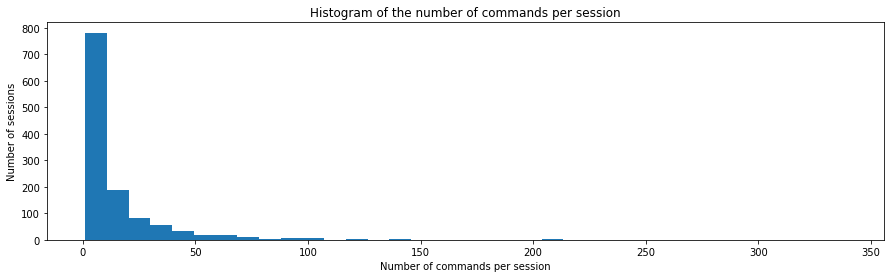

In [85]:
fig = plt.gcf()
fig.set_size_inches(15,4)
plt.hist(sessiondf.nop, bins=35)
plt.title('Histogram of the number of commands per session')
plt.xlabel('Number of commands per session')
plt.ylabel('Number of sessions');

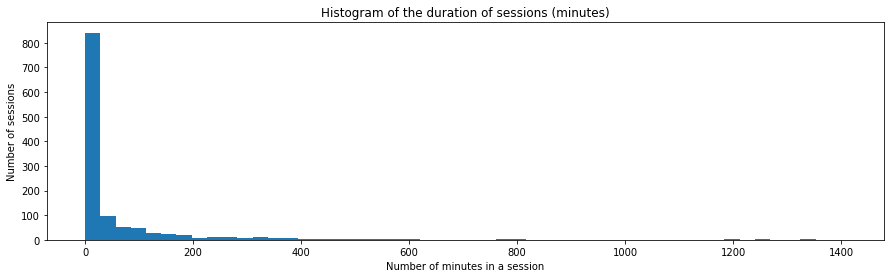

In [86]:
fig = plt.gcf()
fig.set_size_inches(15,4)
plt.hist(sessiondf.dur_in_min, bins=50)
plt.title('Histogram of the duration of sessions (minutes)')
plt.xlabel('Number of minutes in a session')
plt.ylabel('Number of sessions');

This shows that a large number of sessions are very short and the distribution has a long tail.

In [54]:
# find the median duration by user
sessiondf.groupby('user').dur_in_min.median()

user
EN-USER        4.058333
USER40081      2.041667
USERVBS       95.000000
USER_1       195.450000
USER_N         4.116667
USER_PRO       0.758333
Name: dur_in_min, dtype: float64

In [89]:
sessiondf.groupby('user').nop.count()

user
EN-USER        70
USER40081      60
USERVBS         4
USER_1          1
USER_N       1077
USER_PRO        6
Name: nop, dtype: int64

This is interesting that USER_1 and USERVBS have quite high median durations while all the other users have very low median durations but we can see that both these users have very few sessions which can skew the analysis.

**Finding**
We see that for the users that have a lot of sessions a sessions is around 4 minutes.

### Determine the data requirements

We want to use this data to get a feeling of the data storage requirements of this type of data.  Because this is such a limited dataset we need to make a number of assumptions about it to determine what system requirements could be.

First, let's look at the number of records per day.

In [55]:
newdf = newdf.copy()
newdf['day'] = newdf.timestamp.apply(lambda x: f"{x.year}-{x.month:02d}-{x.day:02d}")
newdf.day.value_counts()

2020-07-14    1050
2019-08-17     314
2021-10-06     310
2020-07-21     218
2019-03-24     211
              ... 
2021-02-07       1
2021-08-07       1
2021-02-05       1
2020-12-26       1
2021-02-04       1
Name: day, Length: 526, dtype: int64

Looking at this makes me really question this data.  The top of this with around 300 commands per day is maybe reasonable for a small company but the large number of days with one command concern me.  My first assumption was that these days were on weekends but that is not the case and many of these days are during the week.  If the days were missing completely I would assume that we have just a small subset of data with days removed but that does not seems to be the case.

For now, let's assume the 300 records per day with 250 work days per year for a small company.  This gives us 75,000 records per year.  We can simulate the storage requirement of that by taking the original data and duplicating it to 75,000 records.

In [56]:
year_of_data = pd.concat([df, df, df, df])[:75000]
len(year_of_data)

75000

In [57]:
year_of_data.to_parquet('year_of_data.pq')

In [58]:
%ls -l year_of_data.pq

-rw-r--r--  1 dane  staff  783992 Apr 21 12:46 year_of_data.pq


From this we see that a year of data is 762Kb of data per year.  Assume 1024 companies to track and you end up with a very managable 762Mb of data.  I do not believe this dataset size is representative of a typical company and we need to get better data before we make any data architecture decisions.

## Looking at simultaneous sessions

In [59]:
s = sessiondf[['user', 'start', 'end']].copy().sort_values(by='start')
# set initial session to start at time=0
offset = s['start'].iloc[0]
s['start'] = s['start'] - offset
s['end'] = s['end'] - offset
s.head()

,user,start,end
pgdwm055edgvwqf5kb2rzg55,USER_N,0.000,15727.106
1rh12h55svxboaifku4iy1yd,USER40081,18703.463,50486.023
kivtcb450n1seq45otg1hk55,USER40081,76013.493,76037.346
wkzrqp45nxgppt553uqswjqg,USER40081,79503.226,79746.313
tjwkj2ray4mcai45c3aoty30,USER_N,104836.346,105759.516


To make the data more legible the session start and end times are converted to seconds since the start of the dataset.

As a data check we want to see if any sessions have the same start and end time.  This should not be possible as something has to happen in a session.  Maybe these represent sessions that are abandoned after exactly one command.

In [90]:
s[s.start == s.end]

,user,start,end
ebfxhj55bmx5qgbmpfatyk55,EN-USER,5.254182e+07,5.254182e+07
2xy4bd453zjbuy55gqqj3t55,EN-USER,5.254400e+07,5.254400e+07
34uknr45gtttty550ynnx4z1,USER_N,5.267580e+07,5.267580e+07
czn4tjy5hz5mhy55i1cijwzb,USER_N,5.396872e+07,5.396872e+07
ai1qab453td5db55q0spxqfp,USER_N,5.488311e+07,5.488311e+07
...,...,...,...
3kkcyj55or51yo45yd3jgv45,USER_N,7.902802e+07,7.902802e+07
5lhwi345415y1t45j40x0qyt,USER_N,8.000071e+07,8.000071e+07
hqwwwgfxbbdkvy45te13pvi2,EN-USER,8.072102e+07,8.072102e+07
ul12um55epeksoz2mw3fthzr,USER_N,8.076045e+07,8.076045e+07


While there are not many of these, they do seem like bogus data that is not meaningful to us so we will delete those.

Now that we have the session start and end times (in seconds) we want to select one user and look at the number of simultaneous sessions.

In [61]:
sdf = s[(s.user == 'USER40081') & (s.start != s.end)].copy()  # pick a specific user
# Build a new dataframe with start and end events
start_events = pd.DataFrame()
end_events = pd.DataFrame()
start_events['time'] = sdf['start']
start_events['etype'] = 1
end_events['time'] = sdf['end']
end_events['etype'] = -1
events = pd.concat([start_events, end_events]).sort_values(by='time')
events['num_sessions'] = events.etype.cumsum()
# since we want a trasition plot and not a linear plot we have to create some additional data
# for example 
# time num_sessions
#  0     1
#  1     0
#
# needs to become
#  time num_sessions
#  0     1
#  1-delta 1
#  1     0
new_events = events[1:].copy() # we only create new events after the first time
new_events['time'] = new_events['time'] - 1  # this gets the time values
new_events['num_sessions'] = events['num_sessions'].to_list()[:-1]
events = pd.concat([events, new_events]).sort_values(by='time')
events.head(5)

,time,etype,num_sessions
1rh12h55svxboaifku4iy1yd,18703.463,1,1
1rh12h55svxboaifku4iy1yd,50485.023,-1,1
1rh12h55svxboaifku4iy1yd,50486.023,-1,0
kivtcb450n1seq45otg1hk55,76012.493,1,0
kivtcb450n1seq45otg1hk55,76013.493,1,1


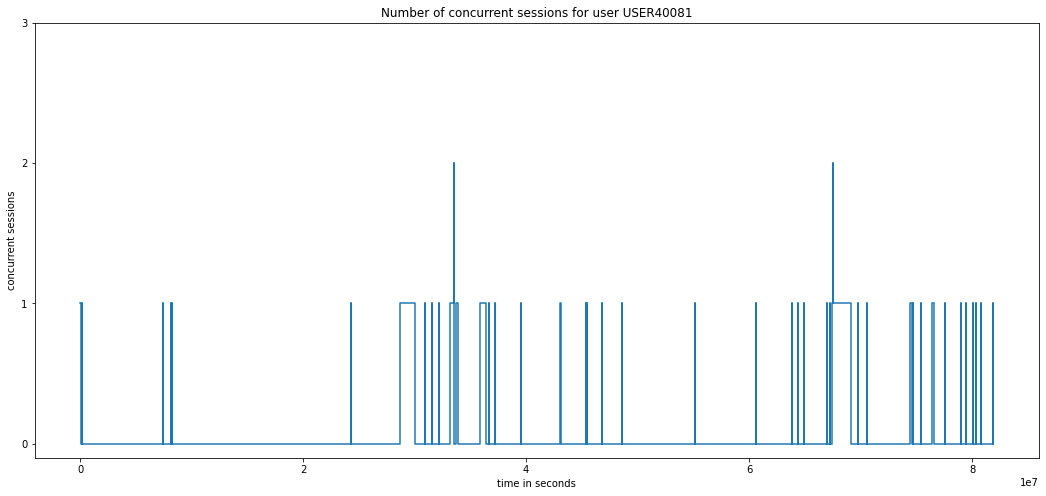

In [91]:
fig = plt.gcf()
fig.set_size_inches(18,8)
plt.plot(events.time, events.num_sessions)
plt.title('Number of concurrent sessions for user USER40081')
plt.yticks([0,1,2,3])
plt.xlabel('time in seconds')
plt.ylabel('concurrent sessions')
plt.show();

**Finding**
This indicates that for this user there does not seem to be anything unusual with only rare (and very short) cases with multiple simultaneous sessions.


## Looking at rate of command execution

For some users the usage is low enough that it is not an issue but the NAPOLEAN user has 16K commands and it would be good to verify these are not programmatically generated.

For this, we will compute the number of seconds between a page display and the previous page as well as the next page.  I compute both so that we can filter out pages that have long gaps between them as that is probably manual interactions.

In [64]:
udf = df[df.USERID == 'USER_N'][['PAGENAME', 'timestamp']]
udf['ts_sec'] = udf.timestamp.apply(lambda x: x.timestamp())
udf = udf.sort_values(by='ts_sec')
udf['ts_sec'] = udf.ts_sec - udf.ts_sec.iloc[0]
#udf['prev_sec'] = pd.rolling_apply(udf.rs_sec, 2, lambda x: x[1]-x[0])
tmp = udf.ts_sec.values
diffs = tmp[1:] - tmp[:-1]
udf['prev_sec'] = np.insert(diffs, 0, 0)
udf['next_sec'] = list(udf.ts_sec.diff())[1:] + [0]
udf.head(20)

,PAGENAME,timestamp,ts_sec,prev_sec,next_sec
72,Login - 172.130.400.165,2019-03-24 18:12:38.087,0.000,0.000,0.013
73,SearchPatients,2019-03-24 18:12:38.100,0.013,0.013,6.110
74,PatientView,2019-03-24 18:12:44.210,6.123,6.110,5.997
75,PatientView,2019-03-24 18:12:50.207,12.120,5.997,0.033
76,SearchPatients,2019-03-24 18:12:50.240,12.153,0.033,0.047
77,PatientView,2019-03-24 18:12:50.287,12.200,0.047,4.970
78,PatientView,2019-03-24 18:12:55.257,17.170,4.970,0.033
79,SearchPatients,2019-03-24 18:12:55.290,17.203,0.033,3.667
80,SearchPatients,2019-03-24 18:12:58.957,20.870,3.667,3.936
81,SearchPatients,2019-03-24 18:13:02.893,24.806,3.936,4.147


We now have a table of the time between commands.  In some cases the command is the first or last in a session and the time will be long so we'll filter those out.  What we really care about are the commands where the time to the previous command and the time to the next command are small, smaller than would be expected by a human operator.  Let's pick 3 seconds.

In [65]:
short_time = 2  # seconds
udf = udf[(udf.prev_sec < short_time) & (udf.next_sec < short_time)]
len(udf)

1205

Now let's look at what the top 10 commands these are.

In [66]:
udf.PAGENAME.value_counts()[:10]

Codes               197
PatientView         193
LedgerV2            156
TransactionEntry    154
SearchPatients       70
EditRecalls          63
EditTreatment        36
AWInsPlan5           34
Misc                 33
FeeSched             23
Name: PAGENAME, dtype: int64

The page named "Codes" has the most hits so let's look at some of those

In [68]:
udf[udf.PAGENAME == 'Codes'].head(20)

,PAGENAME,timestamp,ts_sec,prev_sec,next_sec
405,Codes,2019-03-26 09:08:53.250,1.401752e+05,1.587,0.123
408,Codes,2019-03-26 09:09:00.457,1.401824e+05,0.110,1.643
415,Codes,2019-03-26 09:09:44.647,1.402266e+05,0.960,0.046
418,Codes,2019-03-26 09:09:48.690,1.402306e+05,0.093,1.313
524,Codes,2019-03-27 15:44:59.583,2.503415e+05,1.033,0.060
1374,Codes,2019-07-19 15:52:47.133,1.010041e+07,1.000,0.034
1758,Codes,2019-08-17 02:30:48.883,1.255789e+07,1.163,1.100
1759,Codes,2019-08-17 02:30:49.983,1.255789e+07,1.100,0.884
1760,Codes,2019-08-17 02:30:50.867,1.255789e+07,0.884,1.113
1761,Codes,2019-08-17 02:30:51.980,1.255789e+07,1.113,0.250


This is interesting in that a log of these are on the same date and all very close together.  This definitely does not look like a human interaction but it is possible that the software issues mutiple calls to this page.  We should need to understand a big more about the software to be certain.